In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# creating minibatches
def mini_batch(X, size):
    # generate random integers of shape size*1 and in range 0 to len(X)
    # treat x_bat as indices and return values from X at those indices
    x_bat = X[np.random.randint(len(X), size = (size,1))]
    x_bat = x_bat.reshape(size, X.shape[1], X.shape[2], X.shape[3])
    
    return x_bat

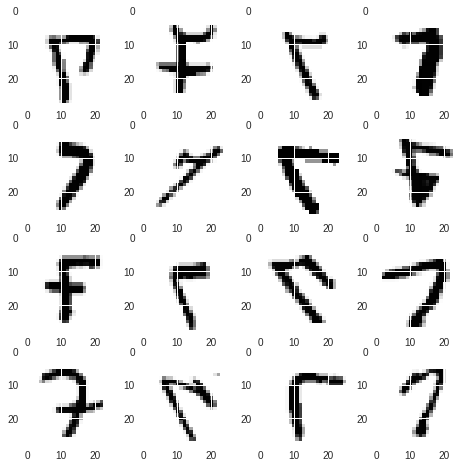

In [235]:
# importing dataset
image_data = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = image_data.load_data()

# selecting only one class
seven_digits_train = np.where(y_train==7)
x_train = x_train[seven_digits_train]

seven_digits_test = np.where(y_test==7)
x_test = x_test[seven_digits_test]

# flipping images left to right
x_train = np.append(x_train, np.flip(x_train, axis=2), axis=0)
x_test  = np.append(x_test, np.flip(x_test, axis=2), axis=0)

# shuffling
np.random.shuffle(x_train)
np.random.shuffle(x_test)

# plotting a random sample from x_train
fig = plt.figure(figsize=(8,8))


col = 4
row = 4
j = 0

for i in range(1, row*col+1):
    fig.add_subplot(row, col, i)
    plt.imshow(x_train[j])
    j+=800
plt.show()

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test  = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

In [0]:
tf.reset_default_graph()

D_in = tf.placeholder(tf.float32, [None, 28,28,1])
G_in = tf.placeholder(tf.float32, [None, 28,28,1])
D_label = tf.placeholder(tf.float32, [None, 1])
G_label = tf.placeholder(tf.float32, [None, 1])

with tf.device("/gpu:0"):
    def Generator(G_input):
        global print_flag_gen
        """
            G_input    : Tensor holds image data
        """
        
        g_conv1 = tf.layers.conv2d(filters=64, inputs=G_input, kernel_size=(5,5), strides=(1,1), activation=tf.nn.leaky_relu, padding="same")
        g_pool1 = tf.layers.max_pooling2d(g_conv1, pool_size=(2,2) ,strides=(2,2), padding="same")
        g_norm1 = tf.layers.batch_normalization(g_pool1)
        
        g_conv2 = tf.layers.conv2d(g_norm1, filters=128, kernel_size=(5,5), strides=(1,1), activation=tf.nn.leaky_relu, padding="same")
        g_pool2 = tf.layers.max_pooling2d(g_conv2, pool_size=(2,2) ,strides=(2,2), padding="same")
        g_norm2 = tf.layers.batch_normalization(g_pool2)
        
        g_conv3 = tf.layers.conv2d(g_norm2, filters=256, kernel_size=(5,5), strides=(1,1), activation=tf.nn.leaky_relu, padding="same")
        g_pool3 = tf.layers.max_pooling2d(g_conv3, pool_size=(2,2) ,strides=(2,2), padding="same")
        g_norm3 = tf.layers.batch_normalization(g_pool3)
    
        g_conv4 = tf.layers.conv2d_transpose(g_norm3, 128, kernel_size=(2,2), strides=(2,2), activation=tf.nn.leaky_relu, padding="same")
        g_resi4 = tf.image.resize_images(g_conv4, size = (7,7), method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        g_norm4 = tf.layers.batch_normalization(g_resi4)
        
        g_conv5 = tf.layers.conv2d_transpose(g_norm4, 64, kernel_size=(2,2), strides=(2,2), activation=tf.nn.leaky_relu, padding="same")
        g_norm5 = tf.layers.batch_normalization(g_conv5)
        
        g_conv6 = tf.layers.conv2d_transpose(g_norm5, 64, kernel_size=(3,3), strides=(2,2), activation=tf.nn.leaky_relu, padding="same")
        g_norm6 = tf.layers.batch_normalization(g_conv6)
        
        generator = tf.layers.conv2d(g_norm6, 1, kernel_size=(3,3), strides=(1,1), activation="tanh", padding="same")
        
        if print_flag_gen == True:
            print("Input            : ",G_input.shape)
            print("g_conv_block_1   : ",g_norm1.shape)
            print("g_conv_block_2   : ",g_norm2.shape)
            print("g_conv_block_3   : ",g_norm3.shape)
            print("g_deconv_block_1 : ",g_norm4.shape)
            print("g_deconv_block_2 : ",g_norm5.shape)
            print("g_deconv_block_3 : ",g_norm6.shape)
            print("Generator Output : ",generator.shape)
            print_flag_gen = False
            
        return generator

In [0]:
with tf.device("/gpu:0"):
    def Discriminator(D_input, train_flag):
        global print_flag_dis
        """
            D_input    : Tensor holds image data
            train_flag : if True, the layers will be trainable, untrainable otherwise
        """
        
        d_conv1 = tf.layers.conv2d(filters=64, inputs=D_input, trainable=train_flag, kernel_size=(3,3), strides=(1,1), activation=tf.nn.leaky_relu, padding="same")
        d_conv2 = tf.layers.conv2d(d_conv1, 64, kernel_size=(3,3), trainable=train_flag, strides=(1,1), activation=tf.nn.leaky_relu, padding="same")
        d_pool1 = tf.layers.max_pooling2d(d_conv2, pool_size=(2,2) ,strides=(2,2), padding="same")
    
        d_conv3 = tf.layers.conv2d(d_pool1, 128, kernel_size=(3,3), trainable=train_flag, strides=(1,1), activation=tf.nn.leaky_relu, padding="same")
        d_conv4 = tf.layers.conv2d(d_conv3, 128, kernel_size=(3,3), trainable=train_flag, strides=(1,1), activation="relu", padding="same")
        d_pool2 = tf.layers.max_pooling2d(d_conv4, pool_size=(2,2) ,strides=(2,2), padding="same")
    
        d_conv5 = tf.layers.conv2d(d_pool2, 256, kernel_size=(3,3), trainable=train_flag, strides=(1,1), activation=tf.nn.leaky_relu, padding="same")
        d_conv6 = tf.layers.conv2d(d_conv5, 256, kernel_size=(3,3), trainable=train_flag, strides=(1,1), activation=tf.nn.leaky_relu, padding="same")
        d_pool3 = tf.layers.max_pooling2d(d_conv6, pool_size=(2,2) ,strides=(2,2), padding="same")
    
        flat = tf.layers.flatten(d_pool3)
        d_dense1 = tf.layers.dense(flat, 128, trainable=train_flag)
    
        d_dense2 = tf.layers.dense(d_dense1, 64, trainable=train_flag)
    
        d_dense3 = tf.layers.dense(d_dense2, 32, trainable=train_flag)   
    
        discriminator = tf.layers.dense(d_dense3, 1, trainable=train_flag)
        
        if print_flag_dis == True:
            print("input            : ", D_input.shape)
            print("conv_block_1     : ", d_pool1.shape)
            print("conv_block_2     : ", d_pool2.shape)
            print("conv_block_3     : ", d_pool3.shape)
            print("dense 1          : ", d_dense1.shape)
            print("dense 2          : ", d_dense2.shape)
            print("dense 3          : ", d_dense3.shape)
            print("Discrimin output : ", discriminator.shape)
            print_flag_dis = False
            
        return discriminator

In [238]:
print_flag_dis = True
print_flag_gen = True
# to avoid initialization errors generator and discriminator functions are called before tf.global_variables_initializer()
# G_z stands for G(z)
# D_G_z_T stands for D(G(z)) with F means train_flag is False and T means train_flag is True
print("Generator: ")
G_z = Generator(G_in)
print("\n\nDiscriminator: ")
D_G_z_F = Discriminator(G_z, train_flag=False)
D_G_z_T = Discriminator(D_in, train_flag=True)

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_G_z_F, labels=G_label))

d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_G_z_T, labels=D_label))

g_ops = tf.train.AdamOptimizer().minimize(g_loss)
d_ops = tf.train.GradientDescentOptimizer(0.001).minimize(d_loss)

Generator: 
Input            :  (?, 28, 28, 1)
g_conv_block_1   :  (?, 14, 14, 64)
g_conv_block_2   :  (?, 7, 7, 128)
g_conv_block_3   :  (?, 4, 4, 256)
g_deconv_block_1 :  (?, 7, 7, 128)
g_deconv_block_2 :  (?, 14, 14, 64)
g_deconv_block_3 :  (?, 28, 28, 64)
Generator Output :  (?, 28, 28, 1)


Discriminator: 
input            :  (?, 28, 28, 1)
conv_block_1     :  (?, 14, 14, 64)
conv_block_2     :  (?, 7, 7, 128)
conv_block_3     :  (?, 4, 4, 256)
dense 1          :  (?, 128)
dense 2          :  (?, 64)
dense 3          :  (?, 32)
Discrimin output :  (?, 1)


In [0]:
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
sess.run(tf.global_variables_initializer())

# hyperparameters
sample_size = 256
epochs = 501

g_l = []
d_l = []

# here goes the training
for i in range(epochs):
    # create noise sample
    noise = np.random.normal(0, 1,[sample_size, x_train.shape[1], x_train.shape[2], x_train.shape[3]])
    
    # create sample of real images
    real_imgs = mini_batch(x_train, sample_size)/255.0
    # generate fake images from noise
    fake_imgs = sess.run(G_z, {G_in:noise})
    # concatenating fake and real images
    disc_input = np.concatenate((real_imgs, fake_imgs), axis=0)
    # labels for discriminator
    # using soft and noisy labels instead of 0 and 1
    disc_labels = []
    for i in range(len(disc_input)):
        if i < len(disc_input)//2:
            # ~0 for real images
            disc_labels.append(np.random.uniform(0,0.1))
        else:
            # ~1 for real images
            disc_labels.append(np.random.uniform(0.9,1.0))
    disc_labels = np.asarray(disc_labels).reshape(2*sample_size,1)

    
    # labels for real images = 0, rest 1
    disc_labels[len(disc_input)//2] = 0
    
    # train the discriminator
    sess.run(d_ops, {D_in: disc_input, D_label: disc_labels})
    d_l.append(sess.run(d_loss, {D_in: disc_input, D_label: disc_labels}))
    
    # train the generator
    noise = np.random.normal(0, 1,[sample_size, x_train.shape[1], x_train.shape[2], x_train.shape[3]])
    sess.run(g_ops, {G_in: noise, G_label: np.ones([len(noise), 1])})
    g_l.append(sess.run(g_loss, {G_in: noise, G_label: np.ones([len(noise), 1])}))
    
    

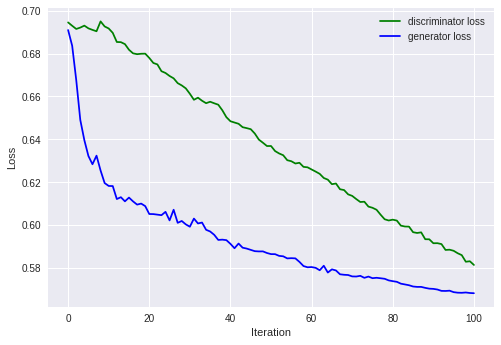

In [215]:
# plotting loss
plt.plot(range(0,len(d_l)), d_l, 'g', label='discriminator loss')
plt.plot(range(0,len(g_l)), g_l, 'b', label='generator loss')
plt.legend(loc='upper right')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

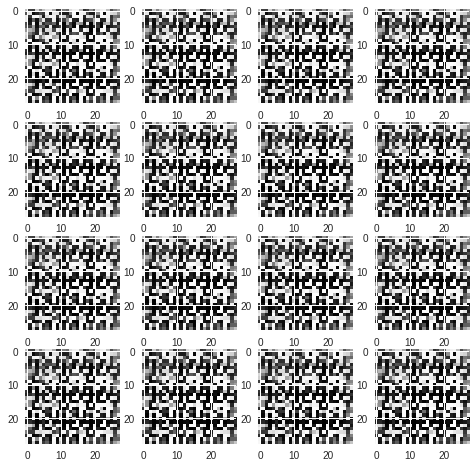

In [216]:
pred = sess.run(G_z, {G_in: np.random.normal(0, 0.1,[sample_size, G_in.shape[1], G_in.shape[2], G_in.shape[3]])})
pred = pred.reshape(sample_size, 28,28)
fig2 = plt.figure(figsize=(8,8))

col = 4
row = 4
j = 0

for i in range(1, row*col+1):
    fig2.add_subplot(row, col, i)
    plt.imshow(pred[j])
    j+=1
plt.show()

In [0]:
############     Resources    ############     
"""
    https://arxiv.org/abs/1406.2661
    https://arxiv.org/abs/1511.06434
    https://github.com/jacobgil/keras-dcgan/blob/master/dcgan.py
    https://medium.com/@utk.is.here/keep-calm-and-train-a-gan-pitfalls-and-tips-on-training-generative-adversarial-networks-edd529764aa9
    https://github.com/soumith/ganhacks
"""